<a href="https://colab.research.google.com/github/JSJeong-me/ResNet/blob/main/Resnet34-3class-aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train a Custom Resnet34 for Image Classification in fastai and PyTorch
Can I computer tell the diffence between a daisy and a dandelion? The answer is yes


This tutorial shows you how to train a state of the art image classification model with Resnet, in PyTorch, using the fastai library.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train Resnet34 image classification model](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train Resnet to recognize your custom classes. We use a [public flowers classification dataset](
https://public.roboflow.com/classification/flowers_classification), which is open source and free to use. You can also use this notebook on your own data.

To train our custom classifier we take the following steps:

* Install fastai dependencies
* Expand our training set via augmentations in Roboflow
* Download custom classificatio data from Roboflow
* Download pretrained Resnet Models
* Run frozen Resent training in fastai
* Find a favorable learning rate
* Run unfrozen training
* Inspect our model's evaluation metrics 
* Run Resnet inference on test images
* Export saved Resnet weights for future inference



# Install fastai dependencies

In [1]:
!ls -l

total 2492
-rw-r--r-- 1 root root 2544292 Jan 27 02:02 rock-paper-scissors.v1.folder.zip
drwxr-xr-x 1 root root    4096 Jan 20 17:27 sample_data


In [ ]:
!cp /content/drive/MyDrive/s2.jpg .

In [ ]:
!unzip ./3class-2021-01-27.zip

In [2]:
!ls -l

total 4060
-rw-r--r-- 1 root root 4133850 Jan 27 02:23 3class-2021-01-27.zip
-rw-r--r-- 1 root root     518 Jan 27 02:18 README.roboflow.txt
drwxr-xr-x 1 root root    4096 Jan 20 17:27 sample_data
drwxr-xr-x 5 root root    4096 Jan 27 02:18 test
drwxr-xr-x 5 root root    4096 Jan 27 02:18 train
drwxr-xr-x 5 root root    4096 Jan 27 02:18 valid


In [3]:
!rm 3class-2021-01-27.zip

In [ ]:
!pip install fastai

In [5]:
from fastai.vision import *

# Downlaod Custom Classification Data

In [6]:
#build fastai dataset loader
np.random.seed(42)
#fastai automatically factors the ./train and ./valid folders into seperate datasets
#more details https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_folder
path = Path('/content/')
data = ImageDataBunch.from_folder(path, size=224, num_workers=4).normalize(imagenet_stats)

In [7]:
#double check the data classes
data.classes

['paper', 'rock', 'scissors']

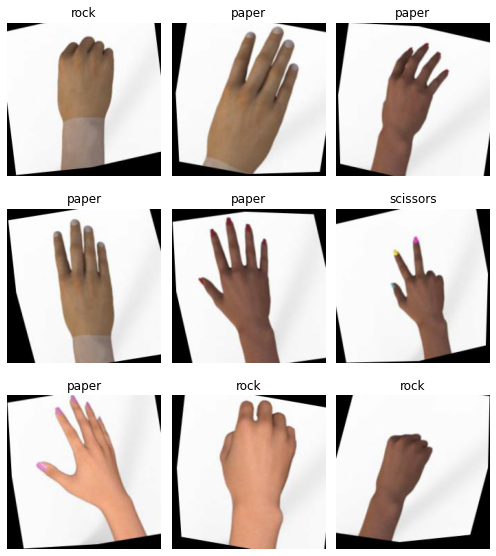

In [8]:
#take a peak at the batch to make sure things were loaded correctly
data.show_batch(rows=3, figsize=(7, 8))


# Set up fastai Resnet model

In [9]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
#print network layers
learn

# Train Custom Resnet Image Classifier

In [13]:
from fastai.callbacks import *
early_stop = EarlyStoppingCallback(learn, patience=20)
save_best_model = SaveModelCallback(learn, name='best_resnet34')

In [14]:
#frozen training step
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(1, callbacks=[early_stop, save_best_model])

Better model found at epoch 0 with valid_loss value: 0.38045668601989746.


In [15]:
#load best model from frozen training
learn.load('best_resnet34')


Learner(data=ImageDataBunch;

Train: LabelList (768 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rock,rock,rock,rock,rock
Path: /content;

Valid: LabelList (72 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rock,rock,rock,rock,rock
Path: /content;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [16]:
learn.unfreeze()

In [17]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    
    
    #loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #return the learning rate that produces the minimum loss divide by 10   
    return lrs[min_loss_index] / 10

In [19]:
optimal_lr = find_appropriate_lr(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [20]:
learn.fit_one_cycle(50, max_lr=slice(optimal_lr/10, optimal_lr), callbacks=[early_stop, save_best_model])


Better model found at epoch 0 with valid_loss value: 0.04383792355656624.
Better model found at epoch 1 with valid_loss value: 0.023545753210783005.
Better model found at epoch 2 with valid_loss value: 0.01623258739709854.
Better model found at epoch 3 with valid_loss value: 0.01164694782346487.
Better model found at epoch 4 with valid_loss value: 0.007958393543958664.
Better model found at epoch 5 with valid_loss value: 0.006049504037946463.
Better model found at epoch 6 with valid_loss value: 0.005841300822794437.
Better model found at epoch 7 with valid_loss value: 0.0040596360340714455.
Better model found at epoch 8 with valid_loss value: 0.0028672495391219854.
Better model found at epoch 9 with valid_loss value: 0.002440987853333354.
Better model found at epoch 10 with valid_loss value: 0.001401697751134634.
Better model found at epoch 11 with valid_loss value: 0.0013693617656826973.
Better model found at epoch 12 with valid_loss value: 0.001355129643343389.
Better model found at 

In [21]:
learn.load('best_resnet34')


Learner(data=ImageDataBunch;

Train: LabelList (768 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rock,rock,rock,rock,rock
Path: /content;

Valid: LabelList (72 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rock,rock,rock,rock,rock
Path: /content;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

# Evaluate Classifier Performance

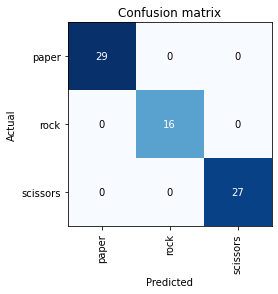

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


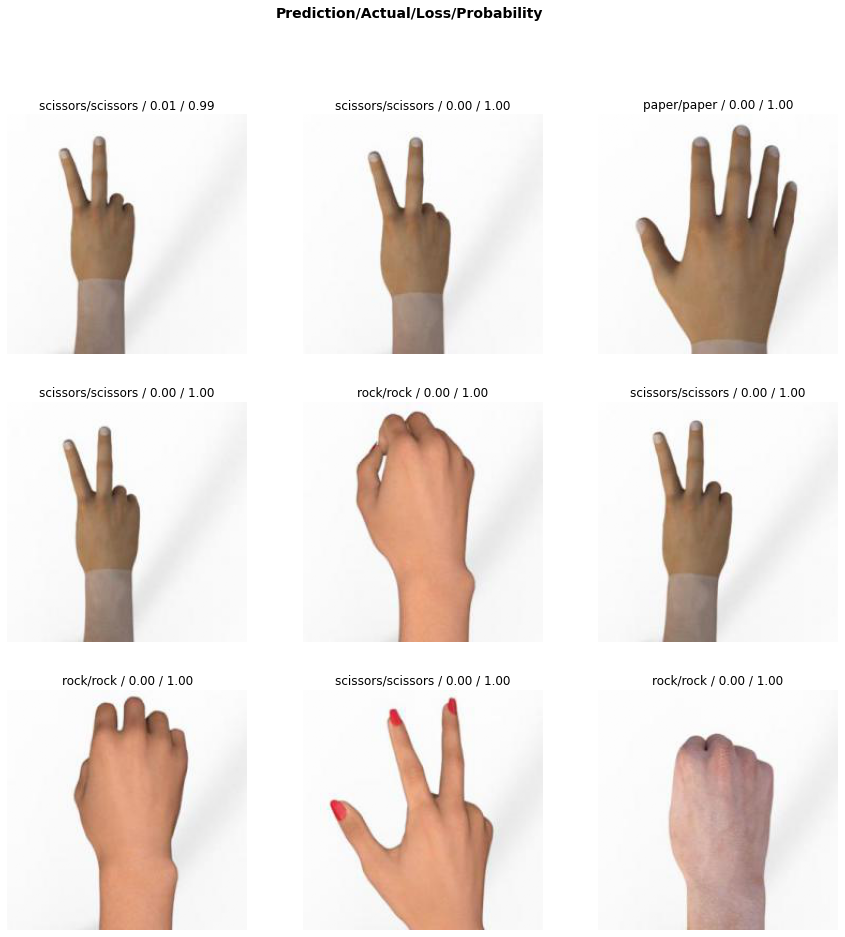

In [23]:
interp.plot_top_losses(9, figsize=(15,15))


/content/s2.jpg
paper


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


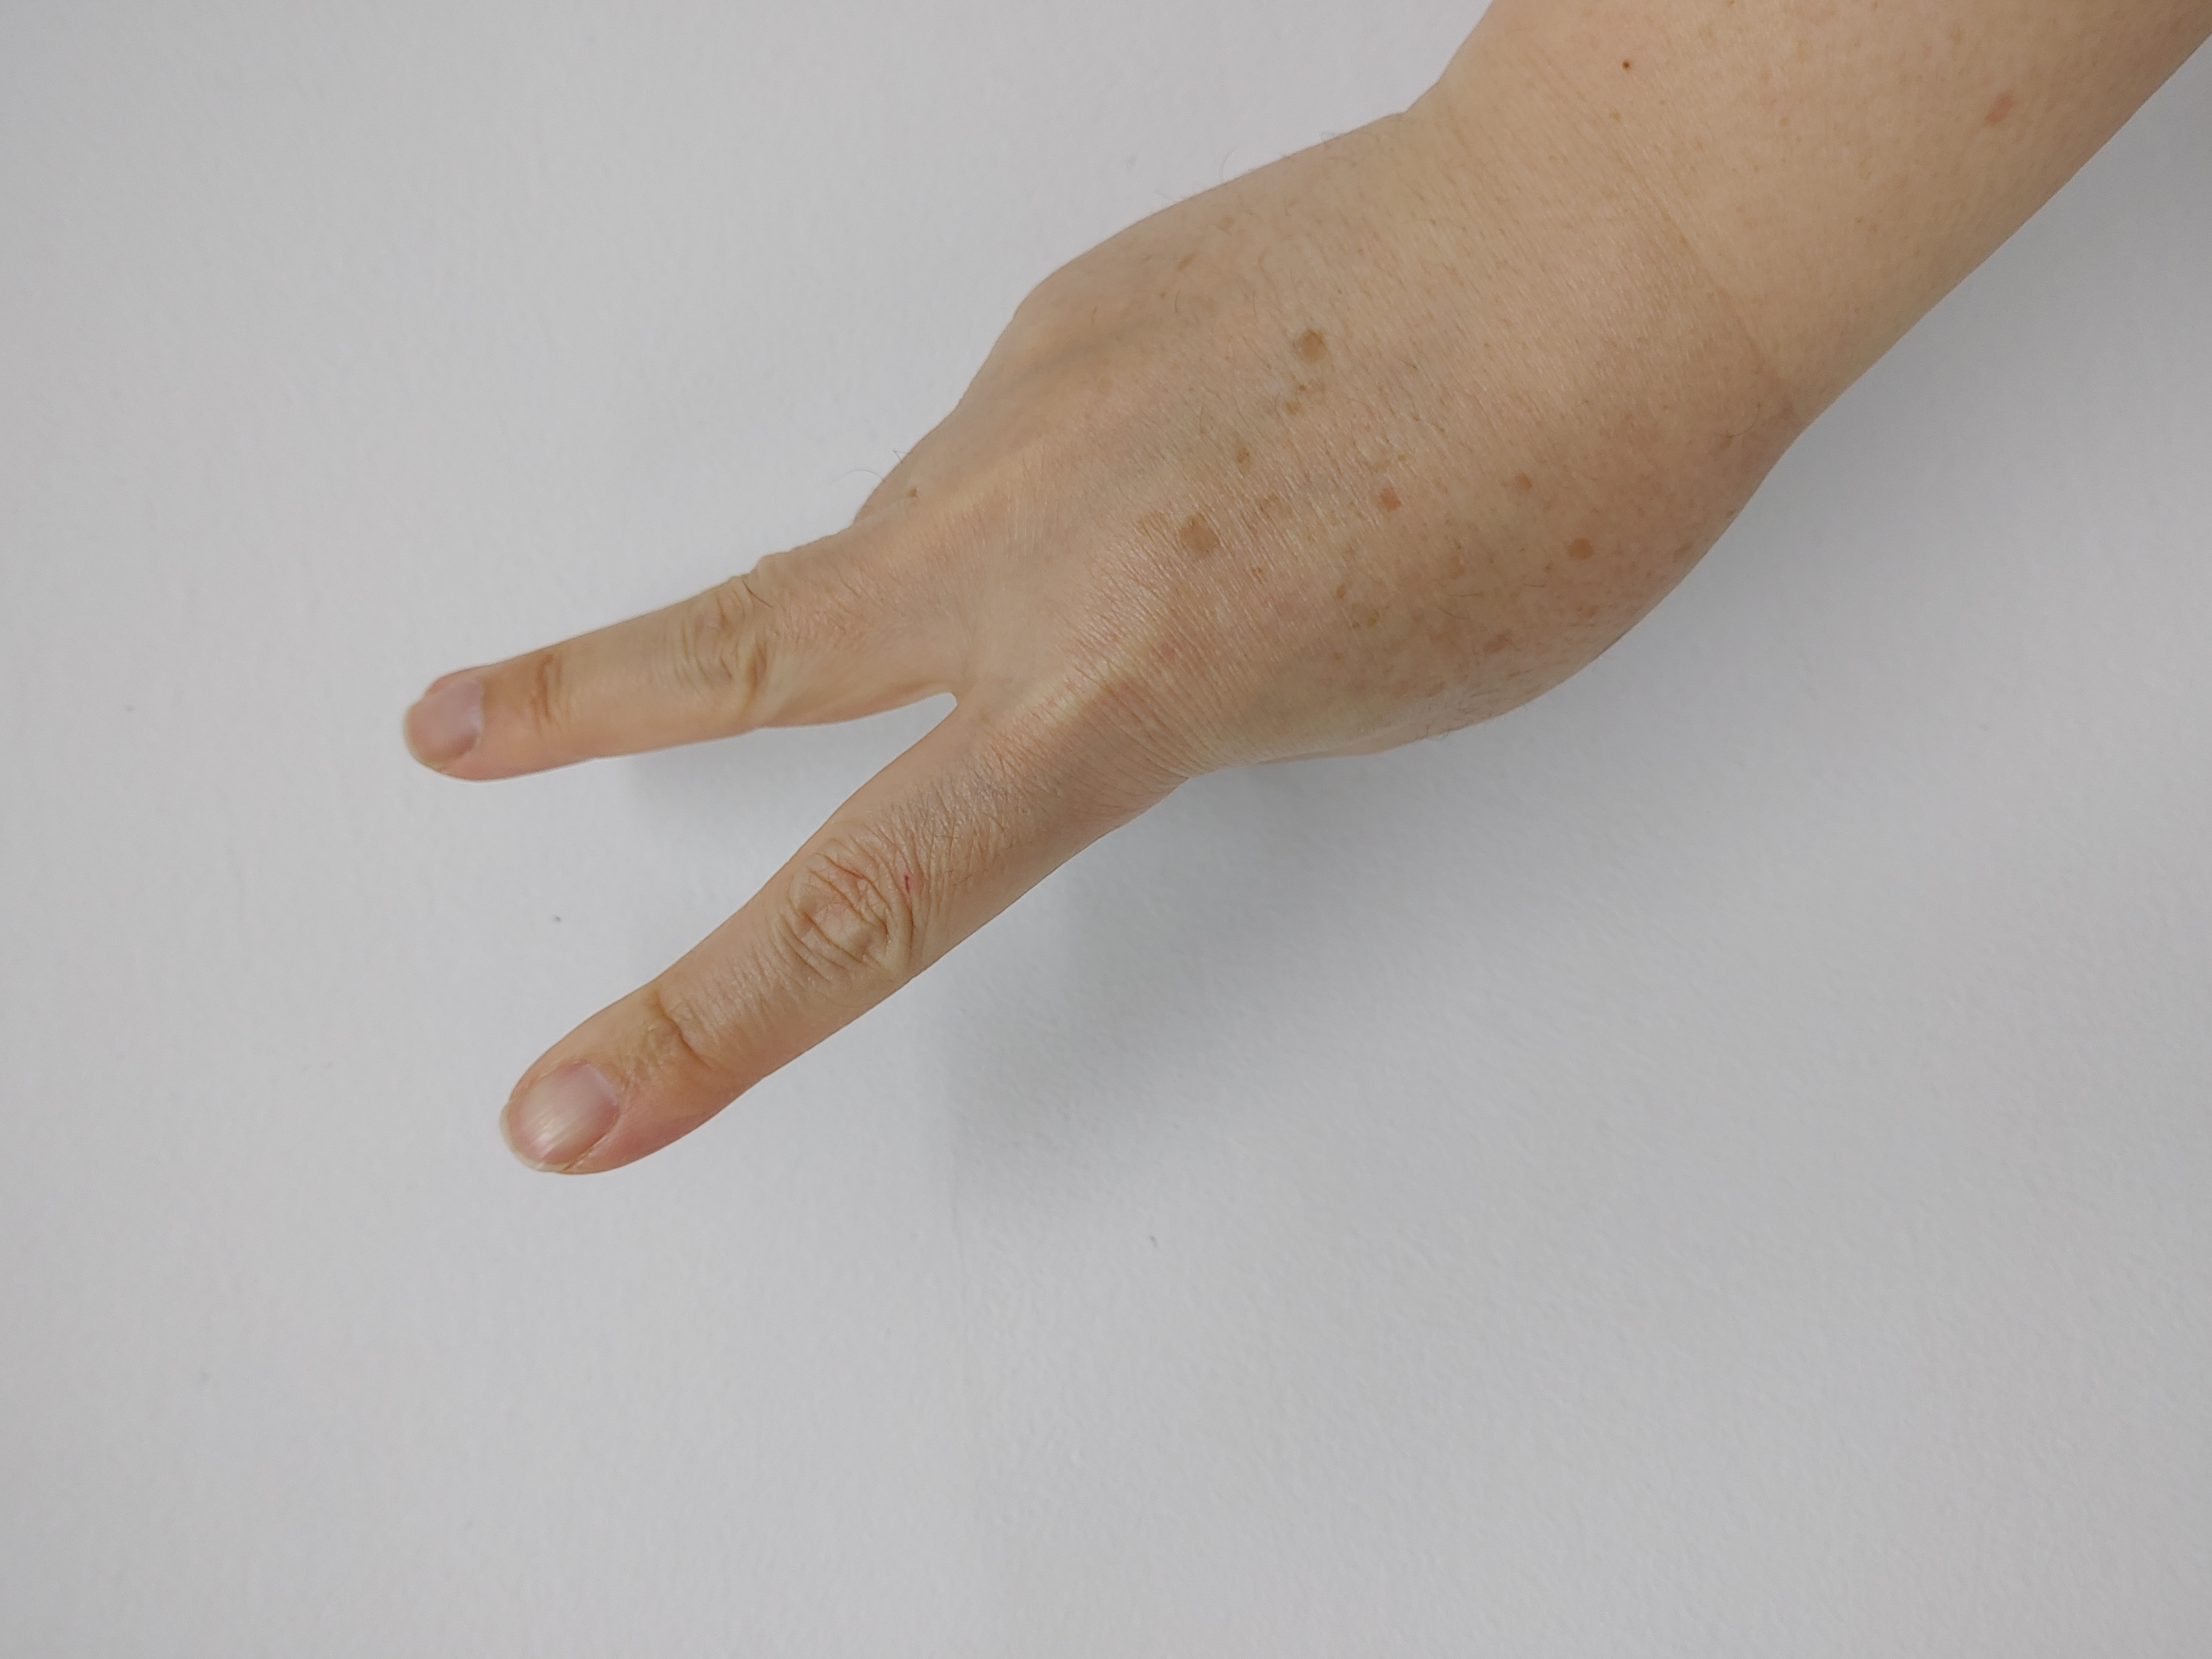

In [31]:
#run inference on test images
import glob
from IPython.display import Image, display

model = learn.model
model = model.cuda()
for imageName in glob.glob('/content/s2.jpg'):
    print(imageName)
    img = open_image(imageName)
    prediction = learn.predict(img)
    #print(prediction)
    print(prediction[0])
    display(Image(filename=imageName))
    print("\n")

# Save custom classification model for future use

In [ ]:
#model is automatically saved with the "save_best_model" callback
%ls models/

best_resnet34.pth  tmp.pth


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.download('./models/best_resnet34.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>